In [1]:
import numpy as np
import pandas as pd

import numpy as np
from pandas.tseries.offsets import BDay
import math
import random

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
%matplotlib inline

from pyfinance import TSeries

from hurst import compute_Hc, random_walk

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hurst import compute_Hc, random_walk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


In [2]:
def ShannonReallyFast(shannon_df):
    #print(shannon_df, 'suka')
    patterns = {'000', '001', '010', '100', '101', '110', '011', '111'}
    shannon_df = pd.DataFrame(shannon_df.copy(), columns=['returns'])
    shannon_df['pattern1'] = np.sign(shannon_df[['returns']])
    shannon_df['pattern2'] = np.sign(shannon_df[['returns']].shift(1))
    shannon_df['pattern3'] = np.sign(shannon_df[['returns']].shift(2))
    shannon_df.dropna(inplace=True)
    shannon_df = shannon_df[(shannon_df.pattern1 != 0.0) & (shannon_df.pattern2 != 0.0) & (shannon_df.pattern3 != 0.0)]
    shannon_df['merged'] = shannon_df.pattern1.astype('str') + shannon_df.pattern2.astype('str') + shannon_df.pattern3.astype('str')
    shannon_df['merged'] = shannon_df['merged'].str.replace('.0', '')
    shannon_df['merged'] = shannon_df['merged'].str.replace('-1', '0')
    prob_df = shannon_df.groupby('merged').count()['returns']
    pattern_df = pd.DataFrame(patterns).set_index(0).sort_values(by=0)
    #prob_df = prob_df.drop(index='111')
    pattern_df = pattern_df.join(prob_df).fillna(0)
    
    ProbSum = 0.0
    for pattern in patterns:
        
        p = pattern_df.loc[pattern] / pattern_df.returns.sum()      
        value = p * np.log2(p)        
        if math.isnan(value):
            continue
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    
    return Shannon_val
    

def ShannonFast(df):
    # wrong pattern match
    df=df[df!=0.0]
    shift_returns = df.shift(1)
    shift_returns2 = df.shift(2)
    shift_returns3 = df.shift(3)
    
    #df['test']  = np.sign(df['returns']).astype('str').dropna() + np.sign(df['shift_returns2']).astype('str').dropna() +  np.sign(df['shift_returns3']).dropna().astype('str')
    
    df =df.dropna(axis=0)
    
    Pattern  = np.sign(df.shift(1).dropna()).astype('str') + np.sign(shift_returns2.dropna()).astype('str') +  np.sign(shift_returns3.dropna()).astype('str')
    
    Pattern=Pattern.dropna().str.replace('.0','')
    patternList = Pattern.dropna().str.replace('.0','').unique().tolist()
    total = 0.0
    ShannonPatterns = {}
    
    for e in patternList:
        ShannonPatterns[e] = 0

    for pattern in ShannonPatterns.keys():        
        value = (len(np.where(Pattern==pattern)[0]))
        ShannonPatterns[pattern] +=  value
        total += value
        
    
    ProbSum = 0.0
    for pattern in ShannonPatterns.keys():
        p = ShannonPatterns[pattern] / total        
        value = p * np.log2(p)        
        if math.isnan(value):
            continue
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    return Shannon_val

def Shannon(df, patternSize):
    
    chunks = []
    for i in range(0, len(df)):
        chunks.append(df[i:i+patternSize])
    
    chunks = chunks[:-patternSize-1]
    
    
    chunks = [np.array2string(x) for x in chunks.copy()]
    
    
    
    
    chunks_set = list(set(chunks))
    
    
    visited = {}
    total = 0
    for el in chunks_set:
        if (el not in visited):
            f = chunks.count(el)
            visited[el] = f
            total = total + f
    ProbSum = 0.0
    for el in visited:
        p = visited[el]/total
        value = p * np.log2(p)
        #visited[el] = value
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    del visited, chunks
    
    
    
    return Shannon_val

def marketMeannes(df_):
    
    m = np.median(df_) 
    nh = 0
    nl = 0
    
    for i in range(1, len(df_)-1):
        Pt = df_[i]
        Py = df_[i-1]
        
        if (Py > m) & (Py > Pt):
            nl += 1
        elif (Py < m) & (Py < Pt):
            nh += 1
        else:
            None
    return (nl+nh)/(len(df_)-1)
        
    
    
def Momersion(df):
    #print(np.where(df == 1)[0])
    #df = df['returns'].copy() * df['returns'].shift(1)
    df = df.copy() * df.shift(1)
    
    df = df.dropna()
    df = np.sign(df)
    pos = len(np.where(df == 1)[0])
    neg = len(np.where(df == -1)[0])
    #zero = len(np.where(df == 0.0)[0])
    if (pos + neg) == 0.0:
        return -1.0
    #print(pos, neg)
    mom = (pos / (pos+neg )) #*100.0
    return mom
# https://pypi.org/project/hurst/
def hurst(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst

def MomersionDouble(df):

    df = df[df!=0.0]
    shift_returns = df.shift(1).fillna(0)
    shift_returns2 = df.shift(2).fillna(0)
    shift_returns3 = df.shift(3).fillna(0)
    Pattern = np.sign(shift_returns * shift_returns2)
    Pattern2= np.sign(shift_returns2 * shift_returns3)
    df = df.dropna()

    pp = len(np.where( (Pattern == 1 ) & (Pattern2 == 1 ) )[0])
    pm = len(np.where( (Pattern == 1 ) & (Pattern2 == -1 ) )[0])
    mp = len(np.where( (Pattern == -1 ) & (Pattern2 == 1 ) )[0])
    mm = len(np.where( (Pattern == -1 ) & (Pattern2 == -1 ) )[0])

    total = 50+100*(pp+pm-mp-mm)/(pp + pm + mp+ mm)
    #threshUp = total>=np.sqrt(len(df))

    return total #(total, len(df), np.sqrt(len(df)))

def proportion(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return pp/mm
    
def proportionPos(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return 100.0 * pp/(pp+mm) 

def autoCorrel(df, lag):
    return pd.Series.autocorr(df, lag)


def hurstF(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst


def hurstF2(p):
    lags = range(2,100)


    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

def hurstF3(series):
   

    #H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.na).dropna(), kind='price', simplified=True)
    H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.nan).dropna(), kind='random_walk', simplified=False)
    return H

def hurstF4(series):
   
    
    H, c, data = compute_Hc(series, kind='random_walk', simplified=True)
    return H



def generateRWI2(df):
    MomVal = Momersion(df['returns']) 
    MomDouble = MomersionDouble(df['returns'])
 
    h1 =  hurstF(df[['price']])
    h2 =  hurstF2(df[['price']])
    h3 =  hurstF3(df['price'])

    h4 = hurstF4(df['price'])
   
  
    #df = df.copy().join(autoCorr_features(df[['returns']].copy()), rsuffix='_suka_')
    
    MMIR = marketMeannes(df['returns'])
    
    MMIP = marketMeannes(df['price'])
    ShannonVal = ShannonFast(df['returns'])
    prop = proportionPos(df['returns'])
    correl_1 = autoCorrel(df.returns, 1)
    correl_2 = autoCorrel(df.returns, 2)
    correl_3 = autoCorrel(df.returns, 3)
    correl_4 = autoCorrel(df.returns, 4)
    correl_5 = autoCorrel(df.returns, 5)
    correl_10 = autoCorrel(df.returns, 10)
    correl_20 = autoCorrel(df.returns, 20)
    correl_100 = autoCorrel(df.returns, 100)
    correl_list = [correl_1, correl_2, correl_3, correl_4, correl_5, correl_10, correl_20, correl_100]
    
    var_std = df['returns'].std()
    var_mean = df['returns'].mean()
    var_median = df['returns'].mean()
    
    
    return [MomVal, MomDouble, h1[0], h2[0], h3, h4, MMIR, MMIP, ShannonVal, prop, var_std, var_mean, var_median] + correl_list

def generate_features(df):
    
    
    df['returns'] = np.log(df['price']).pct_change(1)
    
    df['ROC_2'] =  np.log(df['price'].copy()).pct_change(2)
    
    df['ROC_3'] = np.log(df['price'].copy()).pct_change(3)
    df['ROC_5'] = np.log(df['price'].copy()).pct_change(5)
    df['ROC_20'] = np.log(df['price'].copy()).pct_change(20)
    df['ROC_50'] = np.log(df['price'].copy()).pct_change(50)
    df['ROC_100'] = np.log(df['price'].copy()).pct_change(100)
    df['ROC_200'] = np.log(df['price'].copy()).pct_change(200)
    #df['ROC_300'] = np.log(df['price'].copy()).pct_change(300)
    df['ROC_500'] = np.log(df['price'].copy()).pct_change(500)
    
    
    df['abs_returns'] = np.abs( np.log(np.abs(df['price'].copy())).pct_change())
    

    df = df.replace([np.inf, -np.inf], np.nan)
    
    
    
    return df

def transform_series(tmp):
    #tmp = [e[0] if (type(e)==np.ndarray) else e for e in tmp.copy()]
    df = pd.DataFrame(np.asarray(tmp)+100)
    scaler = MinMaxScaler(feature_range=(0.0, 1.0))
    df_ = scaler.fit_transform(df)
    df_ = pd.DataFrame(df_, columns=df.columns,index=df.index)
    df = (100+df_*100)
    return df



In [3]:
main = pd.read_csv('btc hourly dataset/Bitfinex_BTCUSD_1h-3.csv')
main['Date'] = pd.to_datetime(main['Date'],  format='%Y-%m-%d %I-%p')
main = main.sort_values(by='Date').set_index('Date')

main['range'] = 100*(main['High'] - main['Low'])/main['Low']
main['adj_close'] = main['Close'] / (main['High']*0.5 + main['Low']*0.5)
main['adj_close'] = main['adj_close'].replace([np.inf, -np.inf, 0], 0)
main = main.rename(columns={'Close':'price'})


main = main.drop(columns=['Symbol','Volume BTC']).rename(columns={'Volume USD':'volume'})
main['volume_sma_5' ] = main['volume'].rolling(5).mean()
main['volume_sma_20' ] = main['volume'].rolling(20).mean()
main['volume_sma_50' ] = main['volume'].rolling(50).mean()
main['volume_sma_500' ] = main['volume'].rolling(500).mean()

main['volume_roc' ] = main['volume'].pct_change().fillna(0)
main['volume_roc_5' ] = main['volume'].pct_change(5).fillna(0)
main['volume_roc_20' ] = main['volume'].pct_change(20).fillna(0)
main['volume_roc_50' ] = main['volume'].pct_change(50).fillna(0)
main['volume_roc_500' ] = main['volume'].pct_change(500).fillna(0)


main['returns'] = main.price.pct_change().fillna(0)
main['hurst'] = main[['returns']].rolling(500).apply(hurstF4, raw=False) #.plot()

main=main.drop(columns=['Open', 'High', 'Low'])


In [4]:
main['month'] = main.index.month
main['day'] = main.index.day
main['hour'] = main.index.hour
main['week_day'] = main.index.dayofweek

df=main.copy()
df = df.replace([np.inf, -np.inf],0).fillna(0)
res = generate_features(df)

In [5]:
res.shape

(19139, 28)

In [6]:
19139 * 0.8

15311.2

In [7]:
#### ROC_5 model 1
results = []
df = res.drop_duplicates().copy()
df.loc[:,'shift_returns'] = df['ROC_5'].shift(-1).dropna()
df = df[df.shift_returns != 0.0].dropna()
df =df.drop(columns=['ROC_5'])
df=df.drop_duplicates()
y = df.iloc[:, [-1]]
y.shift_returns = np.sign(y.shift_returns)
X = df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train =X.iloc[0:15311]
y_train = y[0:15311]
X_test = X.iloc[15400:]
y_test = y.iloc[15400:]

clf = RandomForestClassifier(n_estimators=1000, max_depth=1000,
                             random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)


D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [8]:
score

0.7459222082810539

In [9]:
X_test.to_pickle('model_1_Xtest.pkl')
y_test.to_pickle('model_1_ytest.pkl')

In [10]:
import pickle
filename = 'model_no1_roc_5.sav'
pickle.dump(clf, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

In [11]:
#### basic
results = []
df = res.drop_duplicates().copy()
df.loc[:,'shift_returns'] = df['returns'].shift(-1).dropna()
df = df[df.shift_returns != 0.0].dropna()

df=df.drop_duplicates()
y = df.iloc[:, [-1]]
y.shift_returns = np.sign(y.shift_returns)
X = df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train =X.iloc[0:15311]
y_train = y[0:15311]
X_test = X.iloc[15400:]
y_test = y.iloc[15400:]

clf = RandomForestClassifier(n_estimators=1000, max_depth=1000,
                             random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)


D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [12]:
X_test.to_pickle('model_0_Xtest.pkl')
y_test.to_pickle('model_0_ytest.pkl')

In [13]:
score

0.54304

In [14]:
filename = 'model_no0_basic.sav'
pickle.dump(clf, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

In [15]:
# start test date 2019-07-13 01:00:00

In [16]:
main = pd.read_csv('btc hourly dataset/Bitfinex_BTCUSD_1h-3.csv')
main['Date'] = pd.to_datetime(main['Date'],  format='%Y-%m-%d %I-%p')
main = main.sort_values(by='Date').set_index('Date')
main = main.resample('5h').mean().drop_duplicates()

main['range'] = 100*(main['High'] - main['Low'])/main['Low']
main['adj_close'] = main['Close'] / (main['High']*0.5 + main['Low']*0.5)
main['adj_close'] = main['adj_close'].replace([np.inf, -np.inf, 0], 0)
main = main.rename(columns={'Close':'price'})


main = main.drop(columns=['Volume BTC']).rename(columns={'Volume USD':'volume'})
main['volume_sma_5' ] = main['volume'].rolling(5).mean()
main['volume_sma_20' ] = main['volume'].rolling(20).mean()
main['volume_sma_50' ] = main['volume'].rolling(50).mean()
main['volume_sma_500' ] = main['volume'].rolling(500).mean()

main['volume_roc' ] = main['volume'].pct_change().fillna(0)
main['volume_roc_5' ] = main['volume'].pct_change(5).fillna(0)
main['volume_roc_20' ] = main['volume'].pct_change(20).fillna(0)
main['volume_roc_50' ] = main['volume'].pct_change(50).fillna(0)
main['volume_roc_500' ] = main['volume'].pct_change(500).fillna(0)


main['returns'] = main.price.pct_change().fillna(0)
main['hurst'] = main[['returns']].rolling(500).apply(hurstF4, raw=False) #.plot()

main=main.drop(columns=['Open', 'High', 'Low'])
main['month'] = main.index.month
main['day'] = main.index.day
main['hour'] = main.index.hour
main['week_day'] = main.index.dayofweek

df=main.copy()
df = df.replace([np.inf, -np.inf],0).fillna(0)
res = generate_features(df)


In [17]:
main.shape

(3826, 19)

In [18]:
3826*0.8

3060.8

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001957FB5DA20>,
      dtype=object)

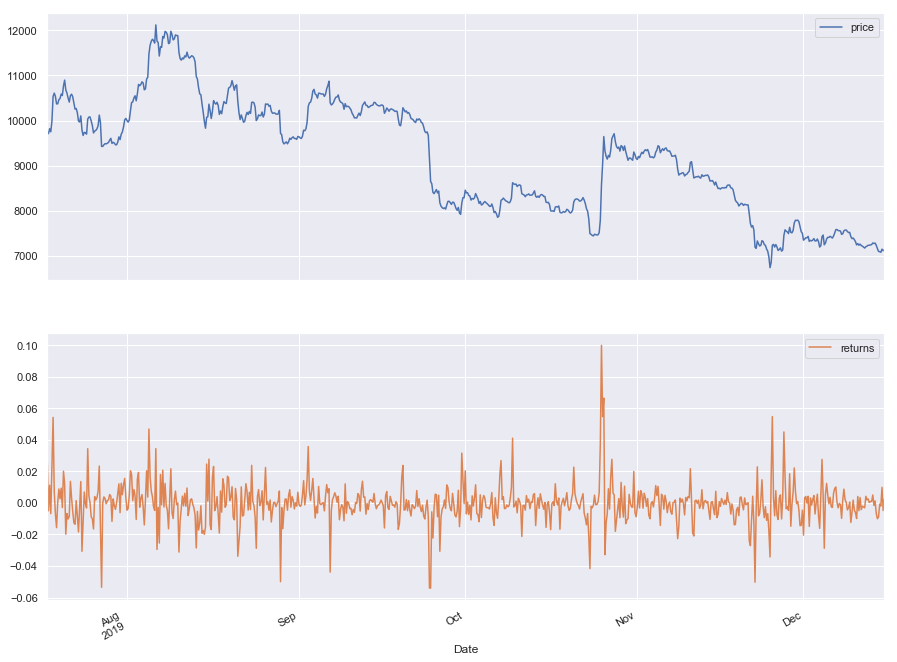

In [19]:
main.iloc[3100:][['price', 'returns']].plot(subplots=(2,1), figsize=(15,12))

In [20]:

results = []
df = res.drop_duplicates().copy()
df.loc[:,'shift_returns'] = df['returns'].shift(-1).dropna()
df = df[df.shift_returns != 0.0].dropna()
y = df.iloc[:, [-1]]
y.shift_returns = np.sign(y.shift_returns)
X = df.iloc[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train =X.iloc[0:3060]
y_train = y[0:3060]
X_test = X.iloc[3100:]
y_test = y.iloc[3100:]

clf = RandomForestClassifier(n_estimators=1000, max_depth=1000,
                             random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)




D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [21]:
X_test.to_pickle('model_2_Xtest.pkl')
y_test.to_pickle('model_2_ytest.pkl')

In [22]:
score

0.6044444444444445

In [23]:
filename = 'model_no2_5hour.sav'
pickle.dump(clf, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))